In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, DataCollatorForLanguageModeling
from datasets import load_dataset

from attentif.mini_bert import MaskedLM

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
dataset = load_dataset("allenai/c4", "realnewslike", split="train[:1000]")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

dataset = dataset.map(
    lambda examples: tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
    ),
    remove_columns=dataset.column_names,
    batched=True,
)

model = MaskedLM(tokenizer.vocab_size, tokenizer.pad_token_id)

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

In [3]:
collator = DataCollatorForLanguageModeling(tokenizer)
batches = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collator)

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

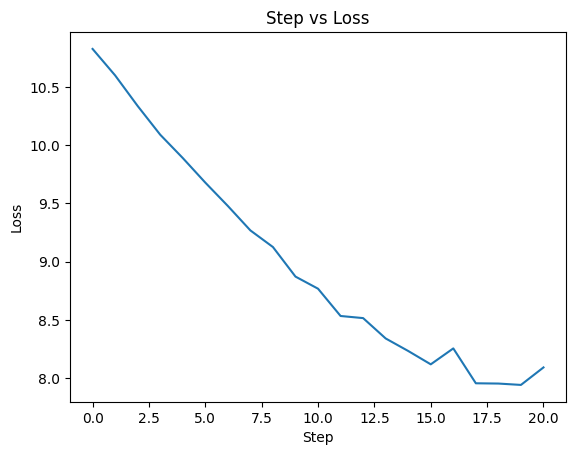

25it [05:47, 13.80s/it]

In [ ]:
losses = []

for (step, batch) in tqdm(enumerate(batches)):
    logits = model(batch["input_ids"], batch["attention_mask"])
    loss = criterion(logits.view(-1, logits.size(-1)), batch["labels"].view(-1))

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    losses.append(loss.item())

    if step % 10 == 0:
        clear_output(wait=True)
        plt.figure()
        plt.plot(losses)
        plt.title("Step vs Loss")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.show()